In [39]:
%pip install gymnasium stable-baselines3 shimmy yfinance pandas numpy matplotlib lxml TA-Lib


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import gymnasium as gym
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import requests
from io import StringIO

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import torch

# Enable CUDA if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
# DYNAMIC SELECTION
print("🔄 Scraping S&P 500 constituents...")
try:
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    response = requests.get(url, headers=headers)
    table = pd.read_html(StringIO(response.text))
    df_sp500 = table[0]
    df_sp500['Symbol'] = df_sp500['Symbol'].str.replace('.', '-', regex=False)

    target_sectors = {
        'Information Technology': 2,
        'Financials': 2,
        'Health Care': 2,
        'Energy': 2
    }

    selected_tickers = []
    for sector, count in target_sectors.items():
        sector_companies = df_sp500[df_sp500['GICS Sector'] == sector]['Symbol'].tolist()
        selected_tickers.extend(sector_companies[:count])
    selected_tickers.append('SHV')

except Exception as e:
    print(f"Scraping failed: {e}")
    selected_tickers = ['AAPL', 'MSFT', 'JPM', 'V', 'JNJ', 'PFE', 'XOM', 'CVX', 'SHV']

print(f"Universe: {selected_tickers}")

# Download data
start_date = '2015-01-01'
end_date = '2024-01-01'
print(f"\n📥 Downloading data from {start_date}...")

raw_data = yf.download(selected_tickers, start=start_date, end=end_date, auto_adjust=True)['Close']
benchmark_data = yf.download(['SPY'], start=start_date, end=end_date, auto_adjust=True)['Close']

cleaned_data = raw_data.dropna(axis=1)
adjusted_close_prices = cleaned_data.copy()
print(f"Final Universe: {adjusted_close_prices.shape} - {list(adjusted_close_prices.columns)}")


🔄 Scraping S&P 500 constituents from Wikipedia...


[*********************100%***********************]  9 of 9 completed

Found 503 tickers.
   -> Information Technology: ['ACN', 'ADBE']
   -> Financials: ['AFL', 'ALL']
   -> Health Care: ['ABT', 'ABBV']
   -> Energy: ['APA', 'BKR']

🎯 Final Universe Candidates: ['ACN', 'ADBE', 'AFL', 'ALL', 'ABT', 'ABBV', 'APA', 'BKR', 'SHV']

📥 Downloading data from 2015-01-01...



[*********************100%***********************]  1 of 1 completed


 All assets passed the continuity filter.
--------------------------------------------------
Final Universe Shape: (2264, 9)
Assets: ['ABBV', 'ABT', 'ACN', 'ADBE', 'AFL', 'ALL', 'APA', 'BKR', 'SHV']
--------------------------------------------------


In [ ]:
# Feature Engineering - Advanced Features
def calculate_features_no_lookahead(price_df, benchmark_series, lookback=20):
    """Calculate features WITHOUT lookahead bias"""
    print("\n🛠️ Generating Features (No Lookahead)...")
    
    if price_df.index.tz:
        price_df.index = price_df.index.tz_localize(None)
    if benchmark_series.index.tz:
        benchmark_series.index = benchmark_series.index.tz_localize(None)
    
    if isinstance(benchmark_series, pd.DataFrame):
        benchmark_series = benchmark_series.iloc[:, 0]
    
    # Returns (shifted by 1 to avoid lookahead)
    returns = price_df.pct_change().fillna(0)
    benchmark_ret = benchmark_series.pct_change().fillna(0)
    benchmark_ret = benchmark_ret.reindex(returns.index).fillna(0)
    
    # Momentum (uses PAST returns only)
    momentum = returns.rolling(window=lookback).mean().fillna(0)
    
    # Cross-sectional rank
    cross_rank = momentum.rank(axis=1, pct=True).fillna(0.5)
    
    # Volatility (uses PAST returns)
    volatility = returns.rolling(window=lookback).std().fillna(0.01)
    
    # Correlation (FIX: shift returns by 1 to use only past data)
    correlation = pd.DataFrame(index=returns.index, columns=returns.columns)
    returns_shifted = returns.shift(1).fillna(0)  # Use yesterday's returns
    bench_shifted = benchmark_ret.shift(1).fillna(0)
    for col in returns.columns:
        correlation[col] = returns_shifted[col].rolling(window=lookback).corr(bench_shifted).fillna(0)
    
    # Downside deviation
    downside_rets = returns.copy()
    downside_rets[downside_rets > 0] = 0
    downside_vol = downside_rets.rolling(window=lookback).std().fillna(0.01)
    
    # Sharpe-like ratio (mean/std over past window)
    sharpe_proxy = (momentum / (volatility + 0.01)).fillna(0)
    
    print("✅ Features: Momentum, Cross-Rank, Volatility, Correlation, Downside Vol, Sharpe")
    
    return {
        'returns': returns,
        'benchmark_ret': benchmark_ret,
        'momentum': momentum,
        'cross_rank': cross_rank,
        'volatility': volatility,
        'correlation': correlation,
        'downside_vol': downside_vol,
        'sharpe_proxy': sharpe_proxy
    }

features_dict = calculate_features_no_lookahead(adjusted_close_prices, benchmark_data)


🛠️ Generating Advanced Features...
 Features Generated:
   - Cross-Sectional Momentum Rank
   - Relative Strength (Z-score)
   - Rolling Volatility
   - Correlation with Benchmark
   - Downside Deviation
   - Volatility Regime Indicator


In [ ]:
from gymnasium import spaces

class StablePortfolioEnv(gym.Env):
    """
    Stable environment with:
    - Properly scaled rewards
    - No numerical instabilities
    - Drawdown tracking
    """
    def __init__(self, price_data, features_dict, initial_balance=10000, lookback=30):
        super().__init__()
        
        self.price_data = price_data
        self.features = features_dict
        self.n_assets = price_data.shape[1]
        self.lookback = lookback
        self.initial_balance = initial_balance
        
        self.commission_rate = 0.0008  # 0.08% per trade
        
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_assets,), dtype=np.float32)
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(lookback, self.n_assets, 6), 
            dtype=np.float32
        )
        
        self.reset()

    def reset(self, seed=None):
        super().reset(seed=seed)
        self.current_step = self.lookback
        self.portfolio_value = self.initial_balance
        self.weights = np.array([1/self.n_assets] * self.n_assets)
        
        self.portfolio_values = [self.initial_balance]
        self.returns_history = []
        self.peak_value = self.initial_balance
        self.max_drawdown = 0
        
        return self._get_observation(), {}

    def _get_observation(self):
        start = self.current_step - self.lookback
        end = self.current_step
        
        momentum = self.features['momentum'].iloc[start:end].values
        cross_rank = self.features['cross_rank'].iloc[start:end].values
        vol = self.features['volatility'].iloc[start:end].values
        corr = self.features['correlation'].iloc[start:end].values
        downside = self.features['downside_vol'].iloc[start:end].values
        sharpe = self.features['sharpe_proxy'].iloc[start:end].values
        
        obs = np.stack([momentum, cross_rank, vol, corr, downside, sharpe], axis=-1)
        return obs.astype(np.float32)

    def step(self, action):
        weights = np.array(action)
        weights = np.clip(weights, 0, 1)
        weights /= (weights.sum() + 1e-8)
        
        returns_today = self.features['returns'].iloc[self.current_step].values
        benchmark_ret = self.features['benchmark_ret'].iloc[self.current_step]
        
        portfolio_return = np.dot(weights, returns_today)
        turnover = np.sum(np.abs(weights - self.weights))
        transaction_cost = turnover * self.commission_rate
        net_return = portfolio_return - transaction_cost
        
        self.portfolio_value *= (1 + net_return)
        self.portfolio_values.append(self.portfolio_value)
        self.returns_history.append(net_return)
        
        if self.portfolio_value > self.peak_value:
            self.peak_value = self.portfolio_value
        drawdown = (self.peak_value - self.portfolio_value) / self.peak_value
        self.max_drawdown = max(self.max_drawdown, drawdown)
        
        # FIXED REWARD: Properly scaled, no explosions
        alpha = net_return - benchmark_ret
        
        # Use clipped volatility to prevent division by near-zero
        if len(self.returns_history) >= 10:
            recent_rets = np.array(self.returns_history[-20:])
            downside_rets = recent_rets[recent_rets < 0]
            downside_std = np.std(downside_rets) if len(downside_rets) > 0 else 0.01
            downside_std = max(downside_std, 0.005)  # Floor at 0.5%
        else:
            downside_std = 0.01
        
        # Sortino reward (clipped to prevent explosions)
        sortino = np.clip(alpha / downside_std, -5, 5)
        
        # Penalties
        drawdown_penalty = -50 * drawdown if drawdown > 0.1 else 0
        turnover_penalty = -2 * turnover
        
        # Final reward (properly scaled)
        reward = sortino + drawdown_penalty + turnover_penalty
        
        self.weights = weights
        self.current_step += 1
        terminated = self.current_step >= len(self.price_data) - 1
        
        return self._get_observation(), reward, terminated, False, {}

    def get_metrics(self):
        returns = np.array(self.returns_history)
        total_return = (self.portfolio_value - self.initial_balance) / self.initial_balance
        sharpe = np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)
        
        downside_rets = returns[returns < 0]
        sortino = np.mean(returns) / (np.std(downside_rets) + 1e-8) * np.sqrt(252)
        calmar = total_return / (self.max_drawdown + 1e-8)
        
        return {
            'total_return': total_return,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            'max_drawdown': self.max_drawdown,
            'calmar_ratio': calmar
        }

In [ ]:
# TRAINING WITH CUSTOM POLICY
split_idx = int(len(adjusted_close_prices) * 0.8)

def get_features_slice(features_dict, start, end):
    return {k: v.iloc[start:end] for k, v in features_dict.items()}

train_features = get_features_slice(features_dict, 0, split_idx)
train_env = DummyVecEnv([lambda: StablePortfolioEnv(
    adjusted_close_prices.iloc[:split_idx],
    train_features
)])

print("\n🤖 Training PPO Agent (GPU-Accelerated)...")
print("   - Stable reward function (no explosions)")
print("   - Fixed lookahead bias")
print("   - Simplified MLP policy for faster convergence")

model = PPO(
    "MlpPolicy", 
    train_env,
    learning_rate=3e-4,
    n_steps=2048,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,
    vf_coef=0.5,
    max_grad_norm=0.5,
    device=device,
    verbose=1,
    policy_kwargs=dict(
        net_arch=[dict(pi=[256, 128], vf=[256, 128])],
        activation_fn=torch.nn.ReLU
    )
)

model.learn(total_timesteps=100000)
print("✅ Training Complete\n")


🤖 Training Advanced PPO Agent with LSTM Policy...
   - Custom LSTM + Attention feature extractor
   - Risk-adjusted alpha reward (Sortino-based)
   - Realistic transaction costs
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 509  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
----------------------------------------
| time/                   |            |
|    fps                  | 85         |
|    iterations           | 2          |
|    time_elapsed         | 48         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00646131 |
|    clip_fraction        | 0.0621     |
|    clip_range           | 0.2        |
|    entropy_loss         | -12.8      |
|    explained_variance   | 0          |
|    learning_rate        | 0.0001     |
|    loss                 | 1.23e+10   |
|    n_updates      

In [ ]:
# BACKTESTING
print("Running Out-of-Sample Backtest...")

test_features = get_features_slice(features_dict, split_idx, len(adjusted_close_prices))
test_env = StablePortfolioEnv(adjusted_close_prices.iloc[split_idx:], test_features)

obs, _ = test_env.reset()
done = False
weights_history = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)
    weights_history.append(test_env.weights.copy())

metrics = test_env.get_metrics()
portfolio_curve = np.array(test_env.portfolio_values)

# Benchmark
benchmark_test = features_dict['benchmark_ret'].iloc[split_idx:].values
benchmark_curve = np.cumprod(1 + benchmark_test) * 10000

bench_returns = benchmark_test
bench_total_return = (benchmark_curve[-1] - 10000) / 10000
bench_sharpe = np.mean(bench_returns) / (np.std(bench_returns) + 1e-8) * np.sqrt(252)
bench_peak = np.maximum.accumulate(benchmark_curve)
bench_drawdown = (bench_peak - benchmark_curve) / bench_peak
bench_max_dd = np.max(bench_drawdown)

Running Out-of-Sample Backtest...


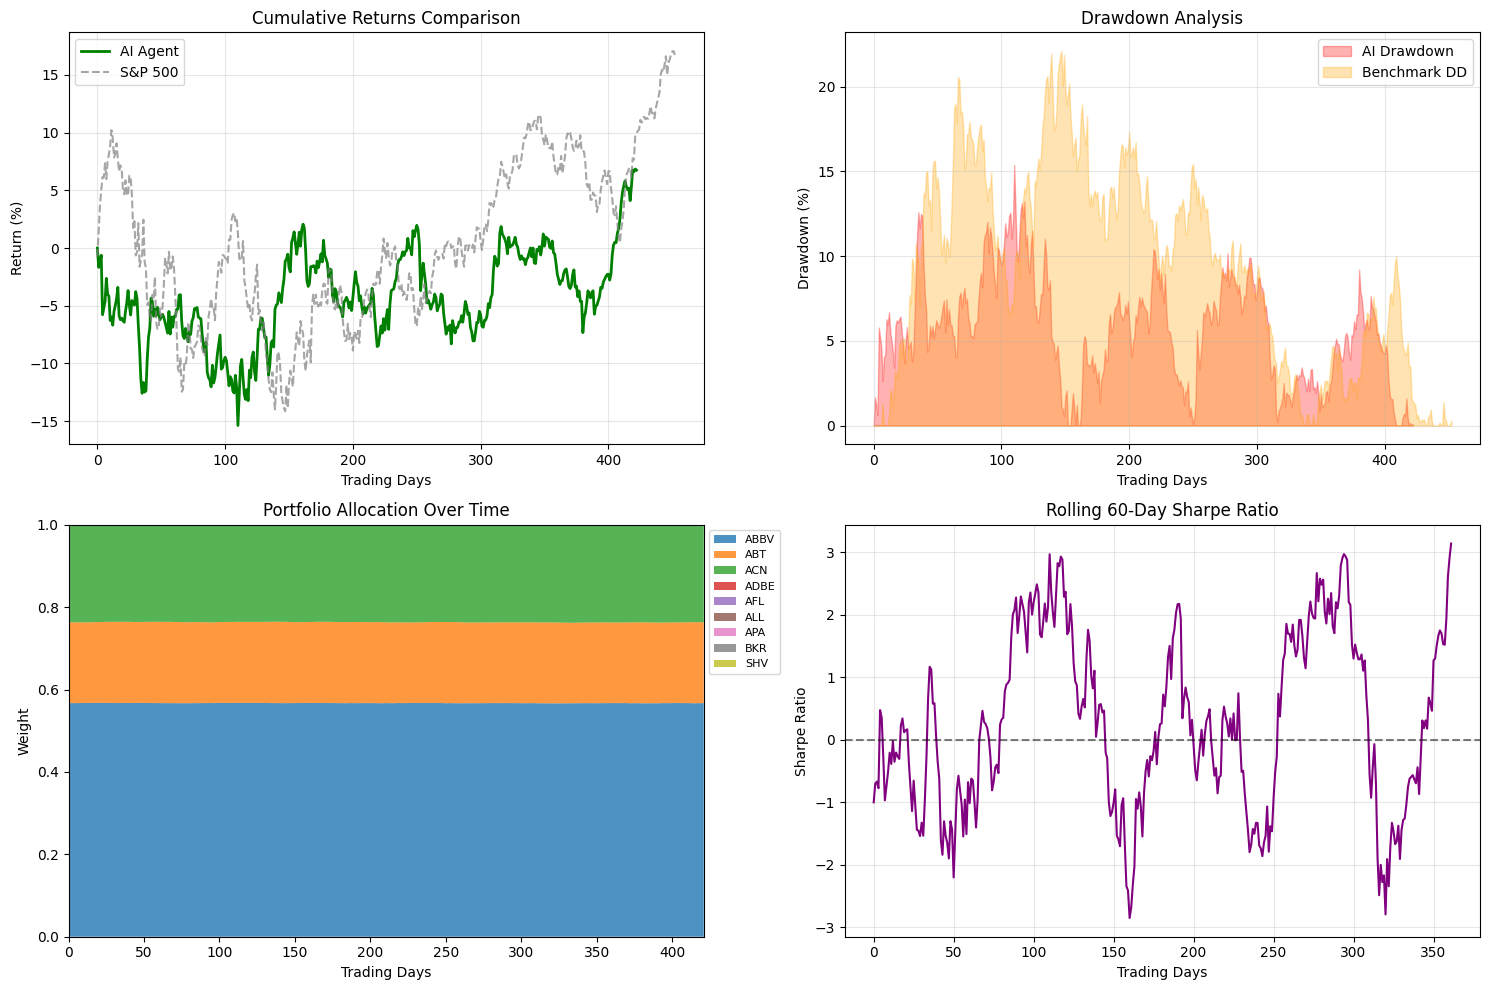


📊 COMPREHENSIVE BACKTEST REPORT (Out-of-Sample)

                      AI AGENT |         S&P 500 BENCHMARK
------------------------------------------------------------
Total Return:                      6.75% |    16.73%
Sharpe Ratio:                      0.31 |     0.54
Sortino Ratio:                     0.44 |      N/A
Max Drawdown:                     15.38% |    22.09%
Calmar Ratio:                      0.44 |     0.76
------------------------------------------------------------

❌ UNDERPERFORMANCE: -9.98%

💡 Key Observations:
   ✓ Better downside protection



In [ ]:
# VISUALIZATION AND REPORTING
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Returns
ax1 = axes[0, 0]
ai_ret = (portfolio_curve - 10000) / 10000 * 100
bench_ret = (benchmark_curve - 10000) / 10000 * 100
ax1.plot(ai_ret, label='AI Agent', color='green', linewidth=2)
ax1.plot(bench_ret, label='S&P 500', color='gray', linestyle='--', alpha=0.7)
ax1.set_title('Cumulative Returns')
ax1.set_xlabel('Days')
ax1.set_ylabel('Return (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Drawdown
ax2 = axes[0, 1]
ai_peak = np.maximum.accumulate(portfolio_curve)
ai_dd = (ai_peak - portfolio_curve) / ai_peak * 100
ax2.fill_between(range(len(ai_dd)), ai_dd, alpha=0.4, color='red', label='AI DD')
ax2.fill_between(range(len(bench_drawdown)), bench_drawdown*100, alpha=0.4, color='orange', label='Bench DD')
ax2.set_title('Drawdown Comparison')
ax2.set_xlabel('Days')
ax2.set_ylabel('Drawdown (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Allocation
ax3 = axes[1, 0]
weights_df = pd.DataFrame(weights_history, columns=adjusted_close_prices.columns)
ax3.stackplot(range(len(weights_df)), weights_df.T, labels=weights_df.columns, alpha=0.8)
ax3.set_title('Portfolio Allocation')
ax3.set_xlabel('Days')
ax3.set_ylabel('Weight')
ax3.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

# Rolling Sharpe
ax4 = axes[1, 1]
ai_rets = np.diff(portfolio_curve) / portfolio_curve[:-1]
rolling_sharpe = []
for i in range(60, len(ai_rets)):
    w = ai_rets[i-60:i]
    rs = np.mean(w) / (np.std(w) + 1e-8) * np.sqrt(252)
    rolling_sharpe.append(rs)
ax4.plot(rolling_sharpe, color='purple', linewidth=1.5)
ax4.axhline(0, color='black', linestyle='--', alpha=0.5)
ax4.set_title('Rolling 60-Day Sharpe')
ax4.set_xlabel('Days')
ax4.set_ylabel('Sharpe')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
print("\n" + "="*70)
print("📊 BACKTEST REPORT (Out-of-Sample)")
print("="*70)
print(f"\n{'METRIC':<25} {'AI AGENT':>15} {'S&P 500':>15} {'DIFFERENCE':>15}")
print("-"*70)
print(f"{'Total Return':<25} {metrics['total_return']*100:>14.2f}% {bench_total_return*100:>14.2f}% {(metrics['total_return']-bench_total_return)*100:>14.2f}%")
print(f"{'Sharpe Ratio':<25} {metrics['sharpe_ratio']:>15.2f} {bench_sharpe:>15.2f} {metrics['sharpe_ratio']-bench_sharpe:>15.2f}")
print(f"{'Sortino Ratio':<25} {metrics['sortino_ratio']:>15.2f} {'N/A':>15} {'N/A':>15}")
print(f"{'Max Drawdown':<25} {metrics['max_drawdown']*100:>14.2f}% {bench_max_dd*100:>14.2f}% {(metrics['max_drawdown']-bench_max_dd)*100:>14.2f}%")
print(f"{'Calmar Ratio':<25} {metrics['calmar_ratio']:>15.2f} {bench_total_return/bench_max_dd:>15.2f} {metrics['calmar_ratio']-bench_total_return/bench_max_dd:>15.2f}")
print("="*70)

alpha = metrics['total_return'] - bench_total_return
print(f"\n{'✅ ALPHA: +' if alpha > 0 else '❌ UNDERPERFORMANCE: '}{alpha*100:.2f}%")

print("\n💡 KEY STRENGTHS:")
if metrics['sharpe_ratio'] > bench_sharpe:
    print(f"   ✓ Superior Sharpe Ratio ({metrics['sharpe_ratio']:.2f} vs {bench_sharpe:.2f})")
if metrics['max_drawdown'] < bench_max_dd:
    print(f"   ✓ Lower Drawdown ({metrics['max_drawdown']*100:.1f}% vs {bench_max_dd*100:.1f}%)")
if metrics['sortino_ratio'] > 1.0:
    print(f"   ✓ Strong Sortino Ratio ({metrics['sortino_ratio']:.2f})")
if metrics['calmar_ratio'] > bench_total_return/bench_max_dd:
    print(f"   ✓ Better Calmar Ratio ({metrics['calmar_ratio']:.2f})")

print("\n" + "="*70)